In [1]:
from importlib import reload
import numpy as np
from scipy import integrate
from scipy import interpolate
import matplotlib.pyplot as plt
import os
import h5py
import glob

import sys  
sys.path.append('./')
import polytropic as pt
from tqdm.notebook import tqdm

reload(pt)

<module 'polytropic' from 'C:\\Users\\yanlo\\OneDrive - California Institute of Technology\\2020-Centrifugal-loss\\polytropic.py'>

In [2]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True
#matplotlib.rcParams['text.latex.unicode'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams["figure.dpi"] = 100
#matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

## prepare polytropes

In [41]:
M = 2e33
R = 7e10
n = 2
Amp = pt.find_critical_A(n)*0.5

gamma_1 = 5./3.

low_viscosity = True

import scipy.special as special

if not low_viscosity:
    Amp = pt.find_critical_A(n)*0.25
    nu = np.vectorize(lambda x: 1e10)
    fac = 1e-6
    print(Amp)

if low_viscosity:
    Amp = pt.find_critical_A(n)*0.25
    fac = 0.05
    qOm = np.vectorize(lambda x: 0.5*qA(x)/fA(x))
    nu = np.vectorize(lambda x: .005)
    print(Amp)
    
x1 = 5
x1c = 0

while np.abs(x1-x1c)>1e-8:
    fA = np.vectorize(lambda x: Amp*np.exp((-x1*x**2/2+x**3/3)*fac))
    qA = np.vectorize(lambda x: x*Amp*np.exp((-x1*x**2/2+x**3/3)*fac)*(-x1*x+x**2)*fac)
    p = pt.poly(n, fA=fA, qA=qA, gamma=np.vectorize(lambda x: gamma_1))
    x1c = x1
    x1 = p.x1
    print(x1)

p = pt.poly(n, fA=fA, qA=qA, nu=nu, gamma=np.vectorize(lambda x: gamma_1))
p0 = pt.poly(n)

0.003155856224566378
4.415631952904542
4.430259897236311
4.429849877614731
4.429861336655938
4.429861016377496
4.429861025329212


In [45]:
fA(p.x1), p.q(p.x1), p.x1, p0.x1

(array(0.00152935),
 -1.2274756793405164e-10,
 4.429861025079009,
 4.352874585712198)

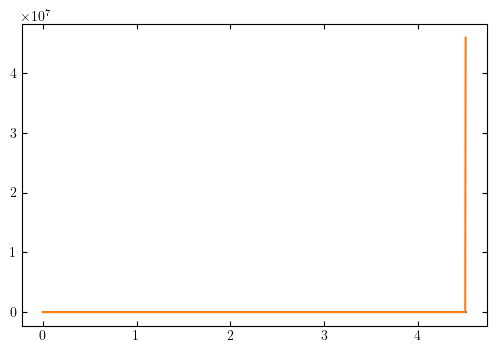

In [36]:
x = np.linspace(1e-10, p.x1, num=1000)
plt.plot(x, p.q(x))
plt.plot(x, p.qq(x))
#plt.plot(x, qOm(x))

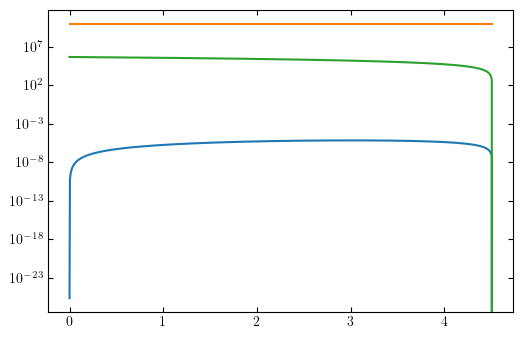

In [37]:
plt.semilogy(x, -p.q(x))
plt.semilogy(x, p.nu(x))
plt.semilogy(x, -p.q(x)*p.nu(x)/(x/p.x1)**2)
# plt.ylim(None, 10)

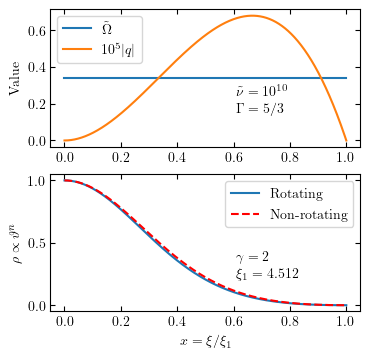

In [39]:
def format_nu(nu):
    if nu> 100:
        return r'10^{%d}'%(np.log10(nu))
    else:
        return '%.3f'%nu

fig, axs = plt.subplots(2, 1, figsize=(4, 4))
x = np.linspace(1e-10, p.x1, num=1000)

ax = axs[0]
ax.plot(x/p.x1, np.sqrt(p.fOm2(x)), label=r'$\tilde{\Omega}$')
if not low_viscosity:
    ax.plot(x/p.x1, -p.q(x)*1e5, label=r'$10^5|q|$')
else:
    ax.plot(x/p.x1, -p.q(x), label=r'$|q|$')
ax.set_ylabel(r'Value')
eq = (r"\hspace{-15 pt}$\tilde{\nu}=%s$ \\ "
       r"$\Gamma=5/3$\\ "
       )%(format_nu(p.nu(1)))
ax.annotate(eq, (0.6, 0.37), xycoords='axes fraction')
ax.legend()

ax = axs[1]
pl = ax.plot(x/p.x1, p.theta(x)**n, label='Rotating')
x = np.linspace(1e-10, p0.x1, num=1000)
ax.plot(x/p0.x1, p0.theta(x)**n, c='r', ls='--', label='Non-rotating')
ax.set_ylabel(r'$\rho\propto\vartheta^n$')
eq = (r"\hspace{-15 pt}$\gamma=2$ \\ "
       r"$\xi_1=%.3f$"
       )%(p.x1)
ax.annotate(eq, (0.6, 0.37), xycoords='axes fraction', ma='left')
ax.legend()

# ax = axs[2]
# ax.plot(x, p.nu(x))
# ax.set_ylabel(r'$\tilde{\nu}$')

axs[-1].set_xlabel(r'$x=\xi/\xi_1$')

if low_viscosity:
    fname = 'plots/polytrope-low-viscosity.pdf'
else:
    fname = 'plots/polytrope-high-viscosity.pdf'
plt.savefig(fname, bbox_inches='tight')
plt.show()

## diff_rot_ad

In [508]:
oms_real = np.linspace(1.8, 5.3, num=81)
oms_imag = np.linspace(-0.5, 0.5, num=21)
xs = np.linspace(p.x1*1e-6, p.x1*(1-1e-6), num=400)

In [509]:
if low_viscosity:
    bvp = pt.osc_diff_rot_ad(p, redef_y4=False, conservation_bds=False, y4_rescale_factor=1.0, rescale_ys=False, y4_bds=False)
else:
    bvp = pt.osc_diff_rot_ad(p, redef_y4=False, conservation_bds=False, y4_rescale_factor=1.0, rescale_ys=False)
bs = pt.bvp_shooting(bvp)

In [510]:
o, s = bs.build_scan(xs, oms_real, oms_imag, scheme='middle1')
bs.set_initial_brackets(d=2)

(array([2.10625+0.j, 3.55   +0.j, 4.8625 +0.j]),
 array([[2.0625 -0.05j, 2.0625 +0.j  , 2.10625+0.05j, 2.15   -0.05j],
        [3.55   +0.05j, 3.59375-0.05j, 3.50625-0.05j, 3.50625+0.j  ],
        [4.81875-0.05j, 4.81875+0.j  , 4.90625+0.05j, 4.90625-0.05j]]))

In [46]:
#bvp.eqs(p.x1*(1-1e-3), 1)

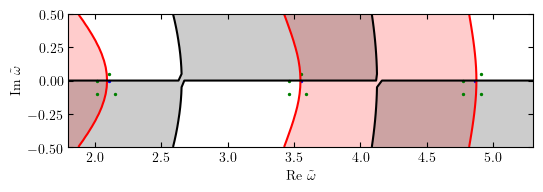

In [512]:
if low_viscosity:
    save_path = 'plots/contour-low-viscosity.pdf'
else:
    save_path = 'plots/contour-high-viscosity.pdf'
bs.plot_zero_contours(d=3, save_path=save_path)

In [513]:
bs.find_eigenvalues(xs, d=3, debug=True, method='Zigzag', Dtol=1e100, iter_max=50, best_bracket=True, xtol=1e-7)

1 (2.092578125+0.0031250000000000305j) 0.048828125000000014 0.20491979088289042
2 (2.09189453125+0.0070312500000000305j) 0.0313829265171721 0.46340882128212163
3 (2.0882202148437496+0.0063476562500000295j) 0.015206301326954864 0.517503189075481
4 (2.0931121826171872+0.0034423828125000303j) 0.008331078047848637 0.22443495131247276
5 (2.0919826507568358+0.0006500244140625294j) 0.004430555682431143 0.07522323827881297
6 (2.093085479736328-0.0003234863281249705j) 0.0020381081785077275 0.023201023361421262
7 (2.09303240776062+0.000539016723632842j) 0.001240401170293908 0.03565532898153436
8 (2.0929681956768036+0.00015606880187991234j) 0.0006634641684400847 0.010376273375657953
9 (2.092906518280506-1.6129016876191235e-05j) 0.00034264195993678384 0.0021938097791397754
10 (2.0929990369826554-3.061592578884991e-05j) 0.0001144443383169126 0.0045581238309594235
11 (2.0929611561819907+2.141296863585395e-06j) 5.951184519329323e-05 0.0016382080786871646
12 (2.092945870151743+7.6267868280705626e-06j)

[(2.0929361118917535-2.2841663242451503e-08j),
 (3.5490448518117113+8.029431385085653e-10j),
 (4.873375949638846-4.461167839252584e-09j)]

In [514]:
bs.find_eigenfunctions(xs, rescale_S=True);

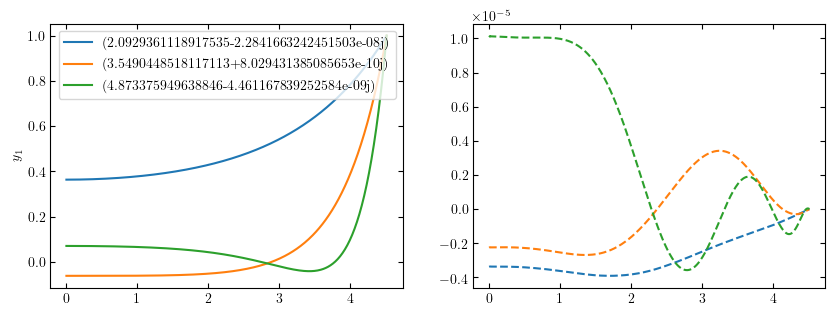

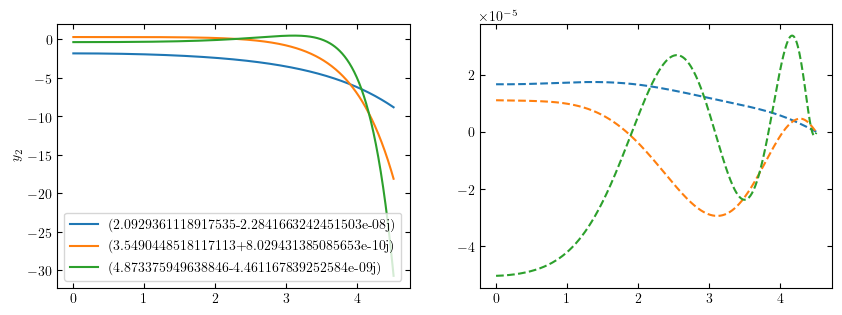

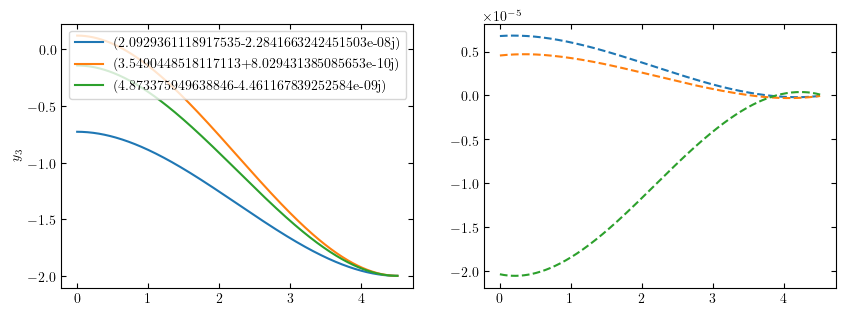

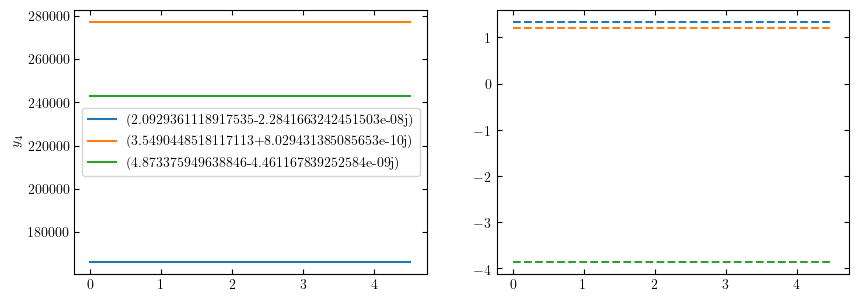

In [515]:
for i in range(4):
    fig, axs = plt.subplots(1, 2, figsize=(10, 3.5))
    for ev, ef in zip(bs.eigenvalues, bs.eigenfunctions):
        if ev <-0.5:
            continue
        axs[0].plot(xs, ef[i].real, label=ev)
        axs[0].legend()
    
    axs[0].set_ylabel(r'$y_{%d}$'%(i+1))

    for ev, ef in zip(bs.eigenvalues, bs.eigenfunctions):
        if ev <-0.5:
            continue
        axs[1].plot(xs, ef[i].imag, label=ev, ls='--')
    plt.show()

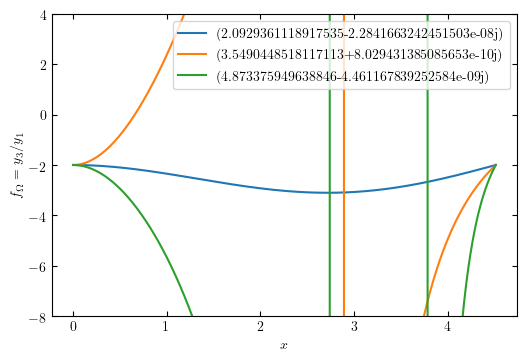

In [516]:
for ev, ef in zip(bs.eigenvalues, bs.eigenfunctions):
    if ev < -0.5:
        continue
    plt.plot(xs, (ef[2]/ef[0]).real, label=ev)
plt.legend()
plt.ylim(-8, 4)
plt.xlabel(r'$x$')
plt.ylabel(r'$f_{\Omega}=y_3/y_1$')
plt.show()

In [517]:
i = 2

y = bs.eigenfunctions[0][i]
om = bs.eigenvalues[0]

rdy_dr = np.diff(y)/np.diff(xs)
rdy_dr = np.insert(rdy_dr, 0, rdy_dr[0])
rdy_dr *= xs

rdy_dr_rhs = np.array([np.dot(bs.bvp.eqs(xs[j], om)[i], bs.eigenfunctions[0][:,j]) for j in range(len(xs))])

C:\Users\yanlo\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\yanlo\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


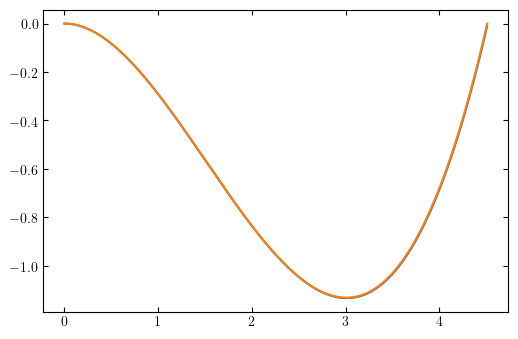

In [518]:
plt.plot(xs, rdy_dr)
plt.plot(xs, rdy_dr_rhs)
# plt.ylim(-1, 10)

C:\Users\yanlo\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\yanlo\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\yanlo\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(-1.0, 1.0)

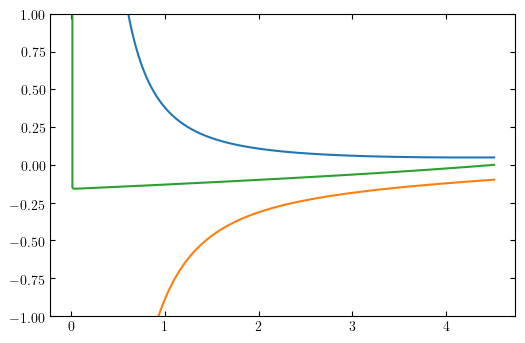

In [519]:
y1 = bs.eigenfunctions[0][0]
y3 = bs.eigenfunctions[0][2]
plt.plot(xs, y1/xs**2)
plt.plot(xs, y3/xs**2)
plt.plot(xs, (2*y1+y3)/xs**2)
plt.ylim(-1, 1)

## rot_rad

Note here om is set to be om2!!!


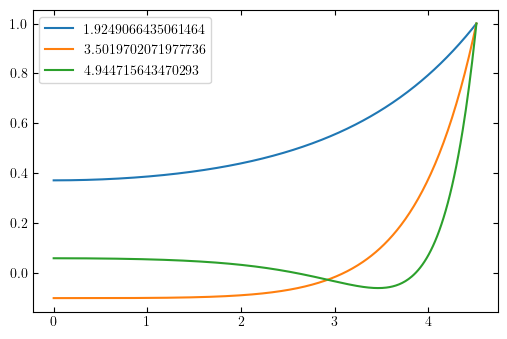

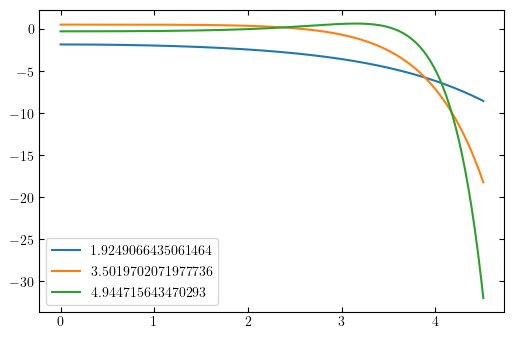

In [520]:
if low_viscosity:
    f_Om = -2
else:
    f_Om = 0.
bvp = pt.osc_rot_rad(p, f_Om=f_Om, rescale_ys=False)
bs_r = pt.bvp_shooting(bvp)
oms_real = np.linspace(0, 30, num=30)
oms_imag = np.linspace(-4, 4, num=41)

xs = np.linspace(p.x1*1e-6, p.x1*(1), num=400)

o, s = bs_r.build_scan(xs, oms_real, oms_imag, scheme='middle1')
bs_r.set_initial_brackets()

bs_r.find_eigenvalues(xs, d=3)
bs_r.find_eigenfunctions(xs)

for ev, ef in zip(bs_r.eigenvalues, bs_r.eigenfunctions):
    plt.plot(xs, ef[0], label=np.sqrt(ev))
plt.legend()
plt.show()

for ev, ef in zip(bs_r.eigenvalues, bs_r.eigenfunctions):
    plt.plot(xs, ef[1], label=np.sqrt(ev))
plt.legend()
plt.show()

In [51]:
#p.nu = np.vectorize(lambda x: -1e-8/(p.rho_r(x)*x**3*np.sqrt(p.fOm2(x))*p.q(x)))

In [ ]:
#plt.semilogy(xs, p.nu(xs))

In [47]:
'''
reload(pt)
print([pt.get_delta_omega(bs_r, p, xs, x, compact_version=False) for x in [0, 1, 2]])
print([pt.get_delta_omega(bs_r, p, xs, x, compact_version=True) for x in [0, 1, 2]])
'''

'\nreload(pt)\nprint([pt.get_delta_omega(bs_r, p, xs, x, compact_version=False) for x in [0, 1, 2]])\nprint([pt.get_delta_omega(bs_r, p, xs, x, compact_version=True) for x in [0, 1, 2]])\n'

In [48]:
#[pt.get_delta_omega(bs_r, p, xs, x, use_background_relation=True) for x in [0, 1, 2]]

In [49]:
'''
y1 = bs.eigenfunctions[0][0]
p1 = bs.eigenfunctions[0][1]
om2_1 = bs.eigenvalues[0]
y2 = bs.eigenfunctions[1][0]
p2 = bs.eigenfunctions[1][1]
om2_2 = bs.eigenvalues[1]

w = p.rho_r(xs)*xs**4
gamma = p.gamma(xs)
Om2 = p.fOm2(xs)
q = p.q(xs)
qq = p.qq(xs)
nur = p.nu(xs)
om = np.sqrt(bs.eigenvalues[0])
f_Om = -2

dy_dr = -(3*y1+1/gamma*p1)/xs
dy_dr[0] = 0
d2y_dr2 = np.diff(dy_dr)/np.diff(xs)
d2y_dr2 = np.insert(d2y_dr2, 0, d2y_dr2[0])

rdp1_dr = np.array([bs.bvp.eqs(xs[i], om2_1)[1,0]*y1[i]+bs.bvp.eqs(xs[i], om2_1)[1,1]*p1[i] for i in range(len(xs))])
rdp1_dr[-1] = 0
d2y_dr2 = 1/xs**2*(-4*xs*dy_dr-1/gamma*rdp1_dr)
d2y_dr2[-1] = d2y_dr2[-2]

L1y1 = -2*xs**2*d2y_dr2-2*xs*dy_dr
L3y1 = 1/q*xs**2*d2y_dr2 + (-qq/q + 1/q+1)*xs*dy_dr
x1 = Om2*(-q)*nur/(om*(xs/p.x1)**2)*(L1y1+f_Om*L3y1)
'''

'\ny1 = bs.eigenfunctions[0][0]\np1 = bs.eigenfunctions[0][1]\nom2_1 = bs.eigenvalues[0]\ny2 = bs.eigenfunctions[1][0]\np2 = bs.eigenfunctions[1][1]\nom2_2 = bs.eigenvalues[1]\n\nw = p.rho_r(xs)*xs**4\ngamma = p.gamma(xs)\nOm2 = p.fOm2(xs)\nq = p.q(xs)\nqq = p.qq(xs)\nnur = p.nu(xs)\nom = np.sqrt(bs.eigenvalues[0])\nf_Om = -2\n\ndy_dr = -(3*y1+1/gamma*p1)/xs\ndy_dr[0] = 0\nd2y_dr2 = np.diff(dy_dr)/np.diff(xs)\nd2y_dr2 = np.insert(d2y_dr2, 0, d2y_dr2[0])\n\nrdp1_dr = np.array([bs.bvp.eqs(xs[i], om2_1)[1,0]*y1[i]+bs.bvp.eqs(xs[i], om2_1)[1,1]*p1[i] for i in range(len(xs))])\nrdp1_dr[-1] = 0\nd2y_dr2 = 1/xs**2*(-4*xs*dy_dr-1/gamma*rdp1_dr)\nd2y_dr2[-1] = d2y_dr2[-2]\n\nL1y1 = -2*xs**2*d2y_dr2-2*xs*dy_dr\nL3y1 = 1/q*xs**2*d2y_dr2 + (-qq/q + 1/q+1)*xs*dy_dr\nx1 = Om2*(-q)*nur/(om*(xs/p.x1)**2)*(L1y1+f_Om*L3y1)\n'

In [50]:
'''plt.plot(xs, d2y_dr2*xs**2)
plt.plot(xs, L1y1)
plt.plot(xs, L3y1)
plt.plot(xs, L1y1+f_Om*L3y1)
# plt.plot(xs, rdp1_dr)
'''

'plt.plot(xs, d2y_dr2*xs**2)\nplt.plot(xs, L1y1)\nplt.plot(xs, L3y1)\nplt.plot(xs, L1y1+f_Om*L3y1)\n# plt.plot(xs, rdp1_dr)\n'

### Make plots

In [521]:
def format_ev(ev):
    ev = complex(ev)
    re = ev.real
    im = ev.imag
    if im == 0:
        return '%.5f'%re
    im1 = float(('%.12e'%im)[:9])
    im2 = np.log10(im/im1)
    if im1>=0:
        sign = '+'
    else:
        sign = ''
    if im2 >= -4:
        return r'$%.2f%s%.5f i$'%(re, sign, im)
    else:
        return r'$%.2f%s%.2f\times10^{%d}\, i$'%(re, sign, im1, im2)

if low_viscosity:
    f_Om = -2
else:
    f_Om = 0.

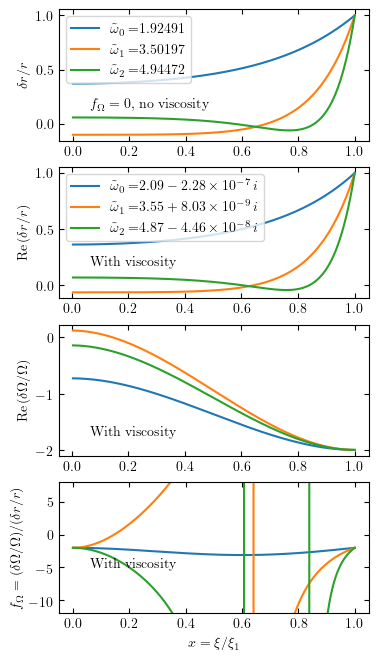

In [522]:
from copy import deepcopy
fig, axs = plt.subplots(4, 1, figsize=(4, 8))

ax =axs[0]
i = 0
for ev, ef in zip(np.sqrt(bs_r.eigenvalues), bs_r.eigenfunctions):
    ax.plot(bs_r.xs/p.x1, ef[0].real, label=r'$\tilde{\omega}_%d=$'%i+format_ev(ev))
    i += 1
ax.legend()
ax.annotate('$f_\Omega=%d$, no viscosity'%f_Om, (0.1, 0.25), xycoords='axes fraction')
ax.set_ylabel(r'$\delta r/r$')

ax =axs[1]
i = 0
for ev, ef in zip(bs.eigenvalues, bs.eigenfunctions):
    xs = bs.xs[2:]
    if not 2333:# low_viscosity:
        ys = (ef[0]/(bs.xs)**2)[2:]
        y1 = (ef[0]/(bs.xs)**2)[-1]
    else:
        ys = ef[0][2:]
        y1 = ef[0][-1]
    ys /= y1
    ax.plot(xs/p.x1, ys.real, label=r'$\tilde{\omega}_%d=$'%i+format_ev(ev))
    #ax.plot(xs, ys.imag)
    i += 1
ax.legend()
ax.annotate('With viscosity', (0.1, 0.25), xycoords='axes fraction')
ax.set_ylabel(r'${\rm Re}\,(\delta r/r)$')


# ax =axs[2]
# i = 1
# for ev, ef in zip(bs.eigenvalues, bs.eigenfunctions):
#     xs = bs.xs[2:]
#     ys = (ef[0]/(bs.xs)**2)[2:]
#     ys /= ys[-1]
#     ax.plot(xs, ys.imag*1e4, label=r'$\tilde{\omega}_%d=$'%i+format_ev(ev))
#     #ax.plot(xs, ys.imag)
#     i += 1
# ax.legend()
# ax.set_ylabel(r'$10^4\,{\rm Im}\,(\delta r/r)$')


ax =axs[2]
i = 1
for ev, ef in zip(bs.eigenvalues, bs.eigenfunctions):
    xs = bs.xs[2:]
    if not 2333:# low_viscosity:
        ys = (ef[2]/(bs.xs)**2)[2:]
        y1 = (ef[0]/(bs.xs)**2)[-1]
    else:
        ys = ef[2][2:]
        y1 = ef[0][-1]
    ys /= y1
    ax.plot(xs/p.x1, ys.real, label=r'$\tilde{\omega}_%d=$'%i+format_ev(ev))
    #ax.plot(xs, ys.imag)
    i += 1
#ax.legend()
ax.annotate('With viscosity', (0.1, 0.15), xycoords='axes fraction')
ax.set_ylabel(r'${\rm Re}\,(\delta \Omega/\Omega)$')


ax = axs[3]
i = 1
for ev, ef in zip(bs.eigenvalues, bs.eigenfunctions):
    ax.plot(bs.xs/p.x1, (ef[2]/ef[0]).real, label='$n=%d$'%i)
    i += 1
#ax.legend(loc='upper left')
ax.annotate('With viscosity', (0.1, 0.35), xycoords='axes fraction')
if low_viscosity:
    ax.set_ylim(-3, 1)
else:
    2333
    ax.set_ylim(-12, 8)
ax.set_xlabel(r'$x=\xi/\xi_1$')
ax.set_ylabel(r'$f_{\Omega}=(\delta \Omega/\Omega)/(\delta r/r)$')

if low_viscosity:
    fname = 'plots/polytrope-modes-low-viscosity.pdf'
else:
    fname = 'plots/polytrope-modes-high-viscosity.pdf'
plt.savefig(fname, bbox_inches='tight')
plt.show()

In [465]:
for i in range(3):
    print(i, end=' & ')
    print('%.6f'%np.sqrt(bs_r.eigenvalues[i]), end= ' & ')
    print('%.6f'%bs.eigenvalues[i].real, end= ' & ')
    print('%.6f'%np.abs(bs.eigenvalues[i].real-np.sqrt(bs_r.eigenvalues[i])), end= ' & ')
    print('%.6f'%bs.eigenvalues[i].imag, end= '')
    if low_viscosity:
        print(' & %.6f'%pt.get_delta_omega(bs_r, p, bs_r.xs, i), end='')
    print('\\\\')

0 & 2.016127 & 2.016074 & 0.000052 & 0.000824 & 0.000688\\
1 & 3.610328 & 3.610890 & 0.000562 & 0.004543 & 0.003592\\
2 & 5.076167 & 5.079960 & 0.003793 & 0.005925 & 0.005396\\


## BAO illustration

In [1015]:
num = 200
x = np.linspace(0, 1, num=num)
y = np.linspace(0, 1, num=num)
x, y = np.meshgrid(x, y)

In [1016]:
def ring(x, y=0, xc=0, yc=0, r=0.05, dr=0.01, amp=1):
    R = np.sqrt((x-xc)**2 + (y-yc)**2)
    return amp*np.exp(-(R-r)**2/2/dr**2)

ring = np.vectorize(ring)

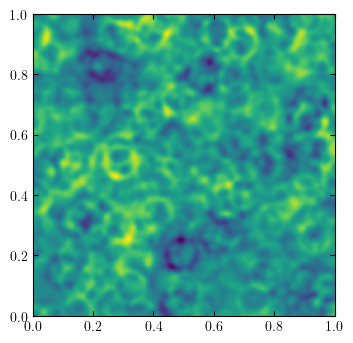

In [1030]:
Z = 0
r = 0.05
dr = 0.01

for i in range(2000):
    amp = np.random.normal()
    xc, yc = 0.5+(0.5+r*4)*(2*np.random.rand(2)-1)
    z = ring(x, y, xc=xc, yc=yc, r=r, dr=dr, amp=amp)
    Z += z
plt.imshow(Z, origin='lower', extent=(0,1,0,1))

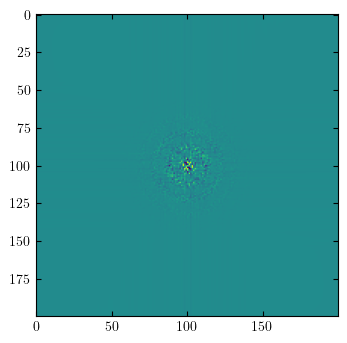

In [1031]:
iZ = np.fft.fft2(Z)
iZ = np.fft.fftshift(iZ)
plt.imshow(iZ.real)

In [1032]:
pk = []
n = len(iZ)
for k in range(0, n//2):
    l, h = k, k+1
    izs = [iZ[i, j] for i in range(n) for j in range(n) if k**2<=(i-n/2)**2+(j-n/2)**2 and (i-n/2)**2+(j-n/2)**2<(k+1)**2]
    izs = np.array(izs)
    ss = np.mean(izs*np.conj(izs)).real
    pk.append([k, ss])
pk = np.transpose(pk)

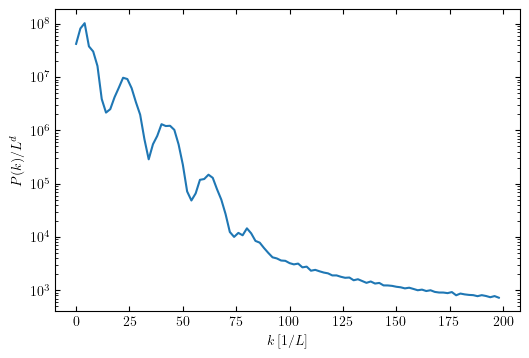

In [1033]:
plt.semilogy(pk[0]*2, pk[1])
plt.xlabel(r'$k\,[1/L]$')
plt.ylabel(r'$P(k)/L^d$')
plt.show()